In [19]:
import numpy as np
from scipy.optimize import minimize
from scipy.optimize import fsolve
from matplotlib import pyplot as plt
import pandas as pd

In [24]:
def calc_price(theta1, theta2, cost, wtp):
    """compute each insurer's price (assumes interior solution)"""
    p1 = (2*theta1+theta2)/3. + cost
    p2 = (2*theta2+theta1)/3. + cost
    return p1, p2
  
    
def calc_t(theta1, theta2, cost, wtp):
    """compute the proportion of people choosing each insurer
    assumes interior solution"""
    p1, p2 = calc_price(theta1, theta2, cost, wtp)
    t_hat = .5 + (p2 - p1)/(2.*cost)
    return t_hat


def calc_profits(theta1,theta2,cost, wtp, mc):
    t= calc_t(theta1, theta2, cost, wtp)
    p1,p2 = calc_price(theta1, theta2, cost, wtp)
    profits1, profits2 = t*(p1-theta1), (1-t)*(p2-theta2)
    mc1,mc2 = mc
    hosp_profit = t*(theta1-mc1) +  (1-t)*(theta2-mc2)
    return hosp_profit, profits1, profits2

    
def outside_simlt(theta1, theta2, cost, wtp,  mc, active=False):
    """outside option in simult case
    assuming listprice high enough"""
    r  = 1 #.25
    t_hat = calc_t(theta1, theta2, cost, wtp)
    mc1,mc2 = mc
    #t_hat = .5
    #print(theta1, theta2,  t_hat)
    if active:
        return (wtp-cost)/2 - mc2 #outside cost is other insurer?
    
    return r*t_hat*(theta2-mc2) + (1-t_hat)*(theta2 -mc2)

#arbitrary outside option...
def nash_in_nash(theta1, theta2, cost, wtp, mc, beta=.5,active=False):
    hosp_profit, profits1, profits2 = calc_profits(theta1, theta2,  cost,  wtp, mc)
    obj = -1*(np.log(max(hosp_profit-outside_simlt(theta1, theta2,cost, wtp , mc, active=active),1e-4))*(1-beta) 
              + np.log(profits1)*beta)
    return obj


COST = 5
WTP = 25
MC = np.array([0,0])

print(nash_in_nash(COST,COST, COST, WTP, MC))

4.147024820051014


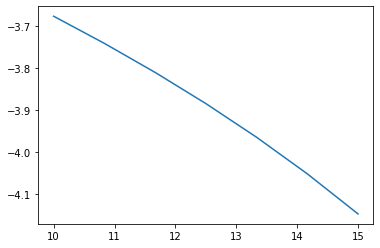

In [33]:
COST = 5
WTP = 40
MC = np.array([0,0])

plt.plot([i for i in np.linspace(2*COST,3*COST,num=7)], 
         [-1*nash_in_nash(i, 10, COST,WTP,MC) for i in np.linspace(1,2*COST,num=7)])

In [34]:
def bargain_helper(theta1, theta2, cost, wtp, mc, beta=.5,active=False):
    """solve each firm 1s optimization holding theta 2 fixed"""
    result = minimize(nash_in_nash, theta1, args=(theta2,cost, wtp, mc, beta, active),
                      method='Nelder-Mead', options={'disp': False})
    return result.x

COST = 5
WTP  = 25
MC = np.array([0,0])

print(bargain_helper(15,15, COST,WTP,MC,beta=.5,active=True))

[14.04830933]


In [38]:
def simult_bargain(theta1, theta2, cost, wtp, mc, betas=[.5,.5],active=False):
    """solve the bargaining problems seperately and iterate for a solution"""       
    
    #loop variables
    diff =  theta1

    maxiter = 10
    while maxiter >=0 and diff > 10e-7:
        #seems as though there is a contraction mapping here, need to think more about why
        theta1 = bargain_helper(theta1, theta2, cost, wtp, mc, beta=betas[0] ,active=active)
        theta2 = bargain_helper(theta2, theta1, cost, wtp, mc[::-1], beta=betas[1],active=active)
        
        #update loop variables
        diff = np.abs(np.max(theta1 - theta2))
        maxiter = maxiter-1
        
    return theta1, theta2

COST = 5
WTP  = 25
MC = np.array([0,0])
print(simult_bargain(10,10,COST,WTP,MC,active=False))
#print(simult_bargain(15,15,COST,WTP,MC,active=True))

(array([13.75]), array([-1.40591056e+155]))


/home/erichschulman/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: overflow encountered in multiply
/home/erichschulman/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: overflow encountered in multiply
/home/erichschulman/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: overflow encountered in multiply
/home/erichschulman/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in add


In [7]:
#generate a bunch of runs with passive and compute costs

def compute_cov(active,nobs=1000):
    mcs = np.random.uniform(low=0.0, high=2.0, size=(2,nobs))
    phis = []
    for i in range(nobs):
        phi = simult_bargain(11.25,11.25,COST,WTP,mcs[:,i],active=active) 
        phis.append(np.array(phi).flatten())

    phis = np.array(phis)
    return np.cov(phis,rowvar=False)

print(compute_cov(active=True))
print(compute_cov(active=False))

[[ 0.16695133 -0.16642846]
 [-0.16642846  0.16657594]]
[[0.22327571 0.1111382 ]
 [0.1111382  0.23242488]]


In [22]:
#just make sure it works for stuff i know is right

def compute_solution(active,nobs=20):
    #mcs = np.random.uniform(low=0.0, high=2.0, size=(2,nobs))
    phis = []
    vs = np.random.uniform(low=25,high=25.5,size=(nobs))
    lambdas = np.random.uniform(low=5,high=6,size=(nobs))
    x = np.concatenate(([vs],[lambdas])) #,mcs
    for i in range(nobs):
        phi = simult_bargain(11.25,11.25,lambdas[i],vs[i],np.array([0,0]),active=active) 
        phis.append(np.array(phi).flatten())
    phis = np.array(phis)
    xx = x.dot(x.transpose())
    xy1 = x.dot(phis[:,0])
    xy2 = x.dot(phis[:,1])
    return np.linalg.inv(xx).dot(xy1),np.linalg.inv(xx).dot(xy2)
    
print(compute_solution(active=True,nobs=10))
print(compute_solution(active=False,nobs=10))

(array([0.50000719, 0.24996672]), array([0.50000916, 0.24995688]))
(array([2.38313461e-07, 9.99998553e-01]), array([-8.24419747e-06,  1.00003860e+00]))


In [25]:
def compute_solution(active,nobs=20):
    
    #set up x variables to solve the model
    phis = []
    vs = np.random.uniform(low=25,high=26,size=(nobs))
    lambdas = np.random.uniform(low=5,high=6,size=(nobs))
    mcs = np.random.uniform(low=0.0, high=2.0, size=(2,nobs))
    x = np.concatenate(([vs],[lambdas],mcs))
    
    #generate a few solutions...
    for i in range(nobs):
        phi = simult_bargain(11.25,11.25,lambdas[i],vs[i],mcs[:,i],active=active) 
        phis.append(np.array(phi).flatten())
        
    #do regression stuff to solve
    phis = np.array(phis)
    xx = x.dot(x.transpose())
    xy1 = x.dot(phis[:,0])
    xy2 = x.dot(phis[:,1])
    return np.linalg.inv(xx).dot(xy1),np.linalg.inv(xx).dot(xy2)

#coeffs are v, lambda, c1, c2
print(compute_solution(active=True,nobs=10))
print(compute_solution(active=False,nobs=10))
    

(array([ 0.49856135,  0.25608195,  0.50789091, -0.49543714]), array([ 0.49858247,  0.25599963, -0.49215877,  0.50454206]))
(array([3.79146919e-06, 9.99982746e-01, 8.00003769e-01, 2.00009992e-01]), array([-1.11222875e-06,  1.00000113e+00,  2.00013296e-01,  7.99999069e-01]))
